In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import from_csv

In [274]:
rounds = [1, 2, 3]
days = [-2, -1, 0, 1, 2]

data = {}

for round_name in rounds:
    for day in days:
        try:
            # Attempt to load data for the given round and day
            activities, trades = from_csv(round_name, day, "../../data")
        except FileNotFoundError:
            # Skip if the file for the specific round and day does not exist
            continue

        products = activities["product"].unique()

        for product in products:
            product_data = activities[activities["product"] == product].reset_index()

            # Ensure the product exists in the data dictionary
            if product not in data:
                data[product] = {}

            # If the day already exists for the product, append new data
            if day in data[product]:
                continue
            else:
                # Otherwise, initialize the day data for the product
                data[product][day] = product_data

In [275]:
combined = {}

for product, days_data in data.items():
    combined_data = []
    last_max_timestamp = 0  # Initialize the last max timestamp

    for day in sorted(days_data.keys()):  # Sort days to process them in order
        day_data = days_data[day].copy()  # Copy the DataFrame for safety

        if "timestamp" in day_data.columns:
            # Adjust timestamps by adding last_max_timestamp + 100
            day_data["timestamp"] += last_max_timestamp

            # Update last_max_timestamp to the max timestamp of the current day
            last_max_timestamp = day_data["timestamp"].max() + 100

        combined_data.append(day_data)

    # Concatenate all the adjusted day data into a single DataFrame for the product
    combined[product] = pd.concat(combined_data).reset_index(drop=True)

In [276]:
ink = combined["SQUID_INK"]
t = ink["timestamp"]
mid_price = ink["mid_price"]

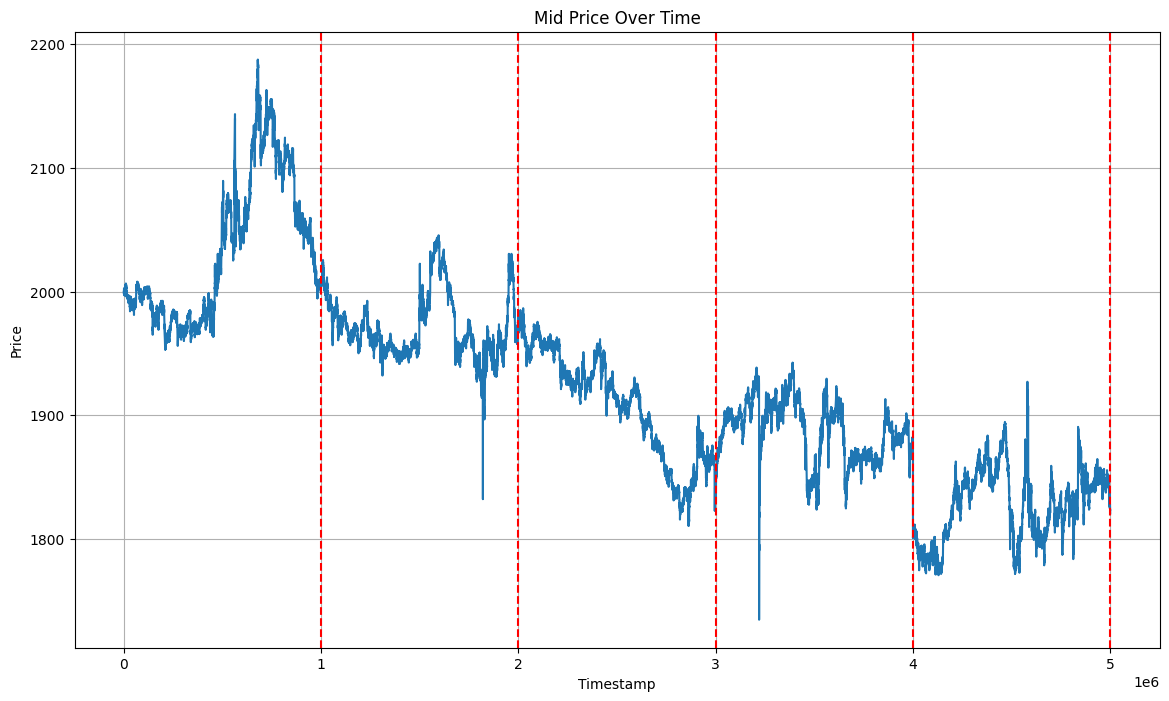

In [277]:
plt.figure(figsize=(14, 8))

plt.plot(t, mid_price)
plt.title("Mid Price Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.grid()

for i in range(5):
    plt.axvline(x=(i+1)*1E6, color='red', linestyle='--', label=f'Event {i+1}')

In [294]:
day_data = combined["SQUID_INK"]
mid = day_data["mid_price"]

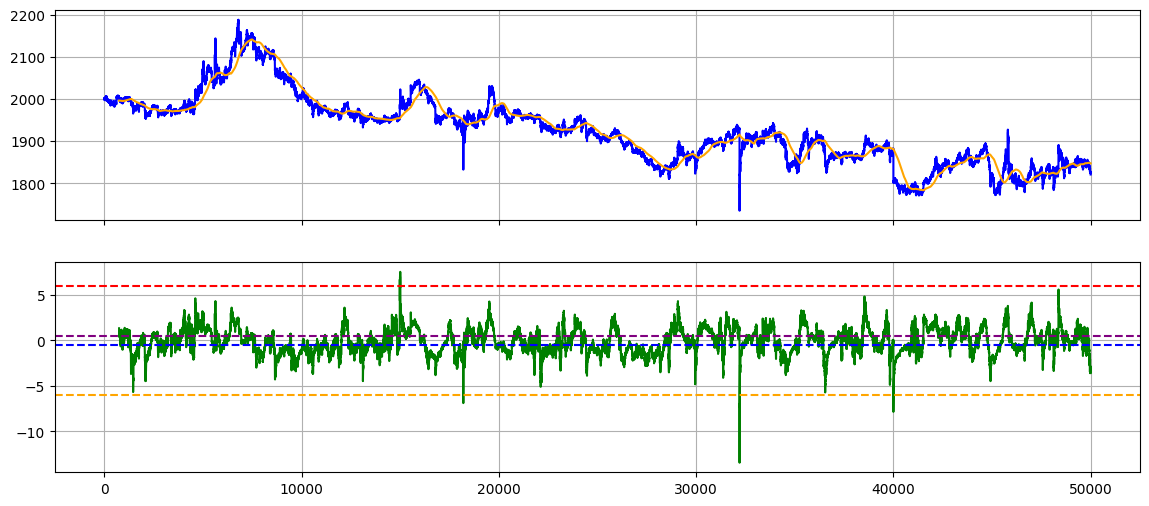

In [328]:
short_window = 750
short_mean = mid.rolling(short_window).mean()
short_std = mid.rolling(short_window).std()
short_z_score = (mid - short_mean) / short_std

long_window = 750
long_mean = mid.rolling(long_window).mean()
long_std = mid.rolling(long_window).std()
long_z_score = (mid - long_mean) / long_std

enter_short_threshold = 6
close_short_threshold = 0.5
enter_long_threshold = -6
close_long_threshold = -0.5

window = short_window
mean = short_mean
trade_signal = short_z_score


enter_short = trade_signal > enter_short_threshold
close_short = trade_signal < close_short_threshold
enter_long = trade_signal < enter_long_threshold
close_long = trade_signal > close_long_threshold

fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
axs[0].plot(mid, label='Mid Price', color='blue')
axs[0].plot(mean, label='Rolling Mean', color='orange')
axs[0].grid()

axs[1].plot(trade_signal, label='Z-Score', color='green')
axs[1].axhline(enter_short_threshold, color='red', linestyle='--', label='Enter Short Threshold')
axs[1].axhline(close_short_threshold, color='purple', linestyle='--', label='Close Short Threshold')
axs[1].axhline(enter_long_threshold, color='orange', linestyle='--', label='Enter Long Threshold')  
axs[1].axhline(close_long_threshold, color='blue', linestyle='--', label='Close Long Threshold')
axs[1].grid()

Entry points: 3, Exit points: 3


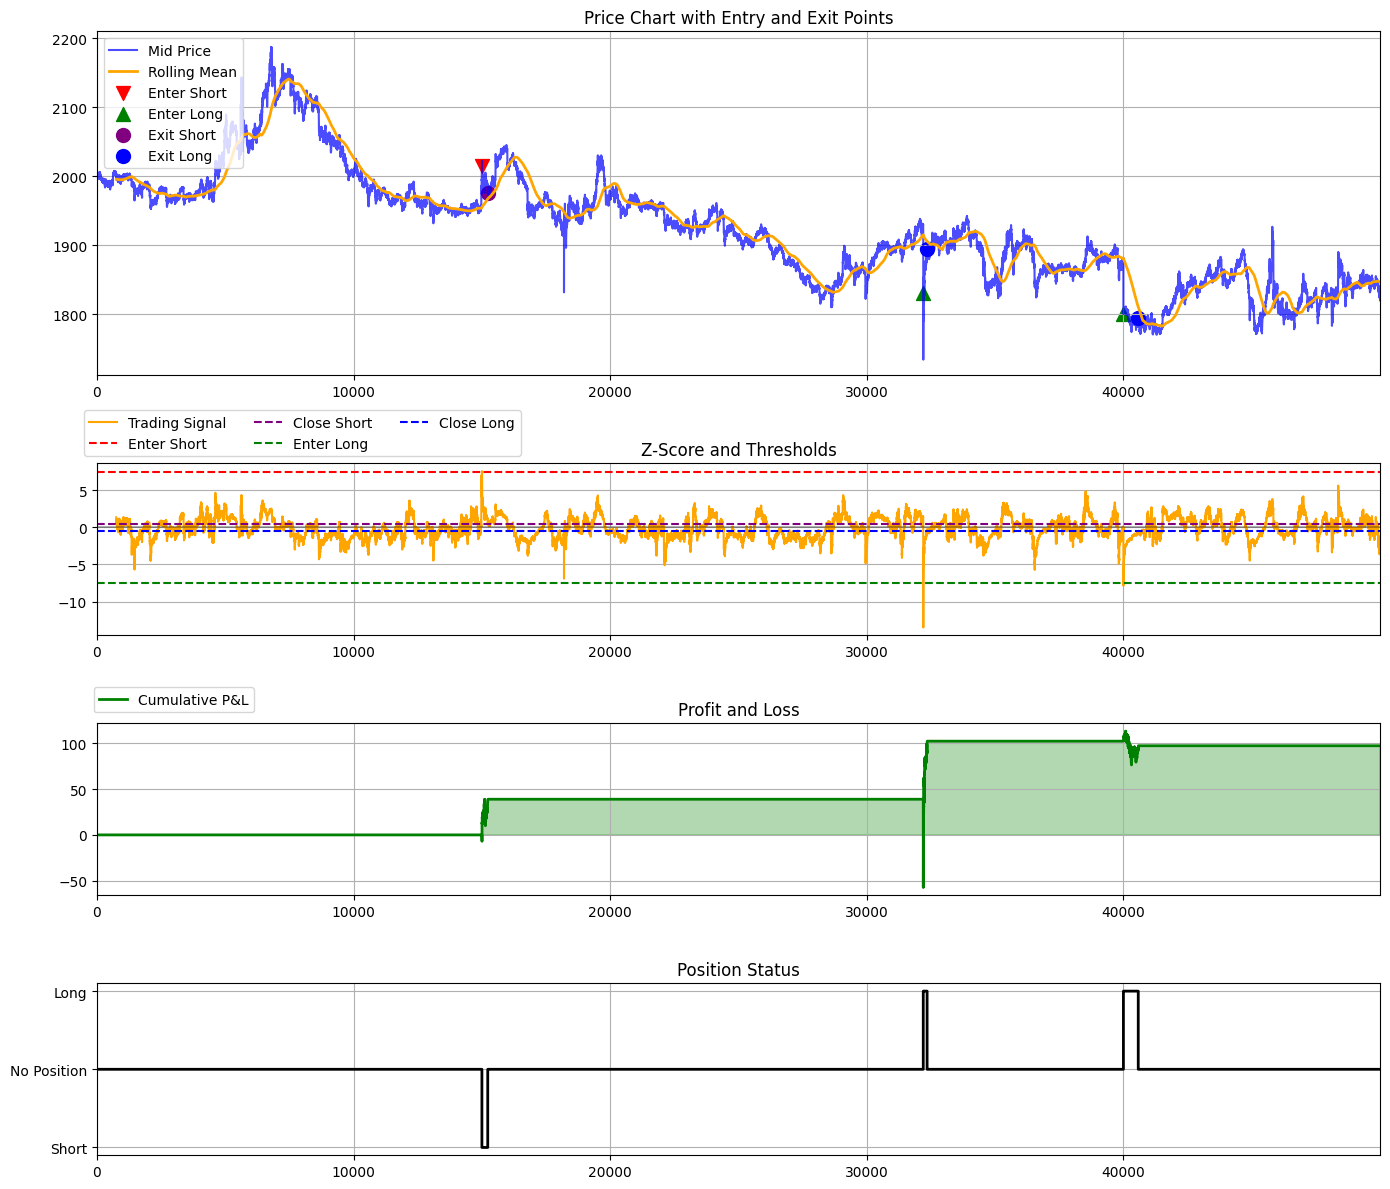

Total Trades: 3
Long Trades: 2
Short Trades: 1
Total P&L from 3 completed trades: 97.50
Average P&L per trade: 32.50
Win rate: 66.67%
Final cumulative P&L: 97.50
Average winning trade: 51.25
Largest winning trade: 63.50
Average losing trade: -5.00
Largest losing trade: -5.00
Win/Loss ratio: 10.25


In [325]:
# Track positions (1 for long, -1 for short, 0 for no position)
position = pd.Series(0, index=mid.index)
entry_points = []
exit_points = []
entry_prices = []
exit_prices = []
entry_types = []  # 'long' or 'short'
exit_types = []   # 'long' or 'short'

# Initialize variables
in_position = 0  # 0: no position, 1: long, -1: short
current_entry_price = 0

# Iterate through the data to identify entry and exit points
for i in range(short_window, len(trade_signal)):
    if in_position == 0:  # No position
        if enter_long.iloc[i] and not enter_long.iloc[i-1]:
            # Enter long position
            in_position = 1
            position.iloc[i:] = 1
            entry_points.append(i)
            entry_prices.append(mid.iloc[i])
            current_entry_price = mid.iloc[i]
            entry_types.append('long')
        elif enter_short.iloc[i] and not enter_short.iloc[i-1]:
            # Enter short position
            in_position = -1
            position.iloc[i:] = -1
            entry_points.append(i)
            entry_prices.append(mid.iloc[i])
            current_entry_price = mid.iloc[i]
            entry_types.append('short')
    elif in_position == 1:  # Long position
        if close_long.iloc[i] and not close_long.iloc[i-1]:
            # Close long position
            in_position = 0
            position.iloc[i:] = 0
            exit_points.append(i)
            exit_prices.append(mid.iloc[i])
            exit_types.append('long')
    elif in_position == -1:  # Short position
        if close_short.iloc[i] and not close_short.iloc[i-1]:
            # Close short position
            in_position = 0
            position.iloc[i:] = 0
            exit_points.append(i)
            exit_prices.append(mid.iloc[i])
            exit_types.append('short')

# Calculate trade-by-trade P&L
trade_pnl = []
print(f"Entry points: {len(entry_points)}, Exit points: {len(exit_points)}")
for i in range(min(len(entry_points), len(exit_points))):
    if entry_types[i] == 'long':
        # For long positions: exit price - entry price
        pnl = exit_prices[i] - entry_prices[i]
    else:
        # For short positions: entry price - exit price
        pnl = entry_prices[i] - exit_prices[i]
    trade_pnl.append(pnl)

# Calculate cumulative P&L and running P&L at each point in time
cumulative_pnl = pd.Series(0, index=mid.index, dtype=float)
running_pnl = pd.Series(0, index=mid.index, dtype=float)

# First set up the cumulative P&L from closed trades
trade_counter = 0
for i in range(len(trade_pnl)):
    exit_idx = exit_points[i]
    pnl = trade_pnl[i]
    cumulative_pnl.iloc[exit_idx:] += pnl
    trade_counter += 1

# Now calculate running P&L that includes unrealized gains/losses
entry_idx = -1
for i in range(window, len(mid)):
    if position.iloc[i] != 0:  # In a position
        if position.iloc[i-1] == 0:  # Just entered
            entry_idx = i
        
        if position.iloc[i] == 1:  # Long position
            # Calculate unrealized P&L: current price - entry price
            running_pnl.iloc[i] = cumulative_pnl.iloc[i] + (mid.iloc[i] - mid.iloc[entry_idx])
        else:  # Short position
            # Calculate unrealized P&L: entry price - current price
            running_pnl.iloc[i] = cumulative_pnl.iloc[i] + (mid.iloc[entry_idx] - mid.iloc[i])
    else:  # Not in a position
        running_pnl.iloc[i] = cumulative_pnl.iloc[i]



# Create enhanced visualization
fig, axs = plt.subplots(4, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [2, 1, 1, 1]})

# Plot 1: Price chart with entries and exits
axs[0].plot(mid, label='Mid Price', color='blue', alpha=0.7)
axs[0].plot(mean, label='Rolling Mean', color='orange', linewidth=2)

# Mark entries on price chart
for i, price in zip(entry_points, entry_prices):
    if entry_types[entry_points.index(i)] == 'long':
        axs[0].scatter(mid.index[i], price, color='green', s=100, marker='^', 
                      label='Enter Long' if 'Enter Long' not in [l.get_label() for l in axs[0].get_legend_handles_labels()[0]] else "")
    else:
        axs[0].scatter(mid.index[i], price, color='red', s=100, marker='v', 
                      label='Enter Short' if 'Enter Short' not in [l.get_label() for l in axs[0].get_legend_handles_labels()[0]] else "")

# Mark exits on price chart - ensuring they appear
for i, price in zip(exit_points, exit_prices):
    exit_type = exit_types[exit_points.index(i)]
    if exit_type == 'long':
        axs[0].scatter(mid.index[i], price, color='blue', s=100, marker='o', 
                      label='Exit Long' if 'Exit Long' not in [l.get_label() for l in axs[0].get_legend_handles_labels()[0]] else "")
    else:
        axs[0].scatter(mid.index[i], price, color='purple', s=100, marker='o', 
                      label='Exit Short' if 'Exit Short' not in [l.get_label() for l in axs[0].get_legend_handles_labels()[0]] else "")

axs[0].set_title('Price Chart with Entry and Exit Points')
axs[0].legend(loc='upper left')
axs[0].set_xlim([mid.index[0], mid.index[-1]])
axs[0].grid()

# Plot 2: Z-score with thresholds
axs[1].plot(trade_signal, label='Trading Signal', color='orange')
axs[1].axhline(enter_short_threshold, color='red', linestyle='--', label='Enter Short')
axs[1].axhline(close_short_threshold, color='purple', linestyle='--', label='Close Short')
axs[1].axhline(enter_long_threshold, color='green', linestyle='--', label='Enter Long')
axs[1].axhline(close_long_threshold, color='blue', linestyle='--', label='Close Long')
axs[1].axhline(0, color='black', linestyle='-', alpha=0.3)
axs[1].set_title('Z-Score and Thresholds')
axs[1].legend(loc='upper center', 
    bbox_to_anchor=(0.16, 1.35),
    ncol=3)
axs[1].set_xlim([mid.index[0], mid.index[-1]])
axs[1].grid()

# Plot 3: P&L over time
axs[2].plot(running_pnl, label='Cumulative P&L', color='green', linewidth=2)
axs[2].fill_between(running_pnl.index, 0, running_pnl, alpha=0.3, color='green', where=(running_pnl > 0))
axs[2].fill_between(running_pnl.index, 0, running_pnl, alpha=0.3, color='red', where=(running_pnl < 0))
axs[2].set_title('Profit and Loss')
axs[2].legend(loc='upper center', 
    bbox_to_anchor=(0.06, 1.25),
    ncol=3)
axs[2].set_xlim([mid.index[0], mid.index[-1]])
axs[2].grid()

# Plot 4: Position indicator (1 for long, -1 for short, 0 for no position)
axs[3].plot(position, color='black', drawstyle='steps-post', linewidth=2)
axs[3].set_yticks([-1, 0, 1])
axs[3].set_yticklabels(['Short', 'No Position', 'Long'])
axs[3].set_title('Position Status')
axs[3].set_xlim([mid.index[0], mid.index[-1]])
axs[3].grid()


plt.tight_layout()
plt.show()

# Calculate basic trading statistics
num_trades = len(entry_points)
num_long_trades = entry_types.count('long')
num_short_trades = entry_types.count('short')

print(f"Total Trades: {num_trades}")
print(f"Long Trades: {num_long_trades}")
print(f"Short Trades: {num_short_trades}")

# Calculate and display P&L statistics
if len(trade_pnl) > 0:
    print(f"Total P&L from {len(trade_pnl)} completed trades: {sum(trade_pnl):.2f}")
    print(f"Average P&L per trade: {sum(trade_pnl)/len(trade_pnl):.2f}")
    print(f"Win rate: {sum(1 for p in trade_pnl if p > 0) / len(trade_pnl):.2%}")
    print(f"Final cumulative P&L: {running_pnl.iloc[-1]:.2f}")
    
    # Calculate more detailed statistics
    if len(trade_pnl) > 1:
        winning_trades = [p for p in trade_pnl if p > 0]
        losing_trades = [p for p in trade_pnl if p <= 0]
        
        if winning_trades:
            print(f"Average winning trade: {sum(winning_trades)/len(winning_trades):.2f}")
            print(f"Largest winning trade: {max(trade_pnl):.2f}")
        
        if losing_trades:
            print(f"Average losing trade: {sum(losing_trades)/len(losing_trades):.2f}")
            print(f"Largest losing trade: {min(trade_pnl):.2f}")
        
        if winning_trades and losing_trades:
            win_loss_ratio = (sum(winning_trades)/len(winning_trades)) / abs(sum(losing_trades)/len(losing_trades)) if sum(losing_trades) != 0 else float('inf')
            print(f"Win/Loss ratio: {win_loss_ratio:.2f}")